In [1]:
# -*- coding: utf-8 -*-:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [2]:
from pcs import tx
from pcs import helper as hlp
from pcs import utils
from pcs import autoencoder as ae

# Parameters

In [3]:
# Channel Parameters
chParam = utils.AttrDict()
chParam.M = 8
chParam.SNR_db = 5

# Auto-Encoder Parameters
aeParam = utils.AttrDict()
aeParam.nLayersEnc  = 1
aeParam.nLayersDec  = 5
aeParam.nFeaturesEnc  = 128
aeParam.nFeaturesDec  = 128

# Training Parameters
trainingParam = utils.AttrDict()
trainingParam.nBatches      = 16
trainingParam.batchSize     = 10_000
trainingParam.learningRate  = 0.01
trainingParam.iterations    = 4000
trainingParam.displayStep   = 500

In [4]:
enc_inp = torch.tensor([[1]], dtype=torch.float)
# AWGN Capacity
AWGN_Cap = 0.5 * np.log2(1 + hlp.dB2lin(chParam.SNR_db, 'dB'))

# Implementation

In [5]:
def sampler(P_M, B):
    samples = torch.empty(0)
    for idx, p in enumerate(P_M):
        occurrences = torch.round(B * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

In [6]:
def generate_AWGN(x_shape, SNR_db):
    noise = torch.randn(x_shape)
    sigma2 = torch.tensor(1) / hlp.dB2lin(SNR_db, 'dB')  # 1 corresponds to the Power
    noise = torch.sqrt(sigma2) * noise
    noise_power = torch.mean(torch.square(torch.abs(noise)))
    return noise, sigma2, noise_power

In [7]:
def plot_PDF( ask, pmf, db):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(ask, pmf)
    ax.set_title(f'SNR = {db} dB')
    ax.grid()
    fig.show()

In [12]:
# Initialize network
encoder = ae.Encoder_Aref_single_layer(in_features=1, out_features=chParam.M, bias=False)
decoder = ae.Decoder_Aref(in_features=1, width=aeParam.nFeaturesDec, out_features=chParam.M)
CEloss = nn.CrossEntropyLoss()

In [13]:
# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=trainingParam.learningRate)

tensor(1., grad_fn=<SumBackward0>)


/tmp/ipykernel_828852/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


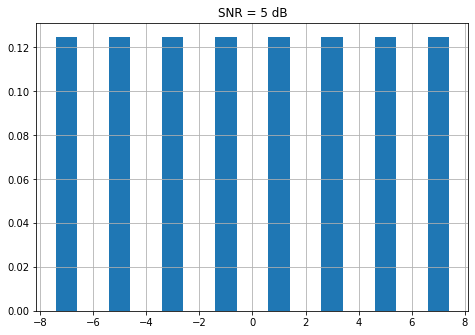

In [14]:
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
constellation_t = torch.tensor(constellation, dtype=torch.float)
plot_PDF(constellation, p_s, chParam.SNR_db)
print(torch.sum(p_s_t))

In [15]:
def sampler(P_M, B):
    samples = torch.empty(0)
    for idx, p in enumerate(P_M):
        occurrences = torch.round(B * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

# Training loop
for j in range(trainingParam.iterations):
    # first generate the distribution
    l_M = encoder(enc_inp)
    P_M = F.softmax(l_M, -1)

    # Sample indexes
    indices = sampler(torch.squeeze(P_M), trainingParam.batchSize).type(torch.LongTensor)  # labels
    # get onehot from sampled indices
    onehot = F.one_hot(indices, chParam.M).float()

    # normalization & Modulation
    norm_factor = torch.rsqrt(utils.p_norm(P_M, constellation_t))
    norm_constellation = torch.mul(constellation_t, norm_factor)
    x = torch.matmul(onehot, norm_constellation)
    should_always_be_one = utils.p_norm(P_M, norm_constellation)

    # Channel
    noise_snr, sigma2, noise_power = generate_AWGN(x.shape, chParam.SNR_db)
    y = torch.add(x, noise_snr)
    #y_power = utils.p_norm(P_M, torch.add(norm_constellation, generate_AWGN(norm_constellation.shape, chParam.SNR_db)[0] ))

    # demodulator
    y_vec = torch.reshape(y, (-1, 1))
    ll = decoder(y_vec)
    app = nn.functional.softmax(ll, 1) #Q(X|Y)

    # loss
    loss = -(torch.sum(-P_M*torch.log(P_M)) -CEloss(ll, indices))

    optimizer.zero_grad()
    loss.backward()

    probs = P_M.transpose(0,1).squeeze()
    cf = - (gradient_correction_factor(app, indices, probs, chParam.M) - probs)

    for name, param in encoder.named_parameters():
        if 'weight' in name:
            param.grad += cf.reshape(-1,1).detach()

    optimizer.step()

    MI = utils.gaussianMI_ASK_Non_Uniform(indices, x, y, norm_constellation, chParam.M, P_M, dtype=torch.double).detach().numpy()

    # Printout and visualization
    if j % int(trainingParam.displayStep) == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f} - always 1: {should_always_be_one :.2} - MI: {MI :.4f} - Cap.: {AWGN_Cap:.4f}')

epoch 0: Loss = 0.0012 - always 1: 1.0 - MI: 0.9794 - Cap.: 1.0287
epoch 500: Loss = -1.0011 - always 1: 1.0 - MI: 1.0057 - Cap.: 1.0287
epoch 1000: Loss = -0.9683 - always 1: 1.0 - MI: 0.9704 - Cap.: 1.0287


KeyboardInterrupt: 

In [16]:
 for param in encoder.parameters():
            print(type(param.data), param.size())
            print(param.data)

<class 'torch.Tensor'> torch.Size([8, 1])
tensor([[-13.7274],
        [-14.9575],
        [-14.3291],
        [-13.9646],
        [-13.9843],
        [-14.3054],
        [-15.1549],
        [-13.6744]])


Power should always be one: tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)


/tmp/ipykernel_828852/4269678781.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


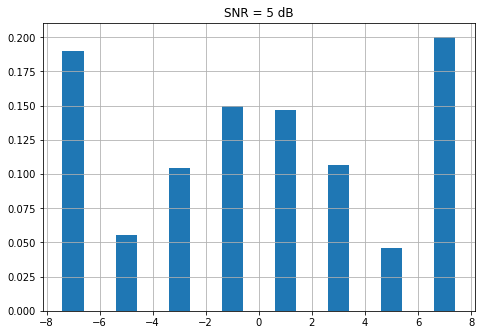

In [17]:
# Data for the plots
p_s_t = F.softmax(encoder(enc_inp), dim=1)
p_s = p_s_t.detach().numpy()[0]
constellation = np.linspace(-chParam.M+1, chParam.M-1, num=chParam.M)
constellation_t = torch.tensor(constellation, dtype=torch.float64)
norm_factor = torch.rsqrt(utils.p_norm(p_s_t, constellation_t))
norm_constellation = norm_factor * constellation_t
print('Power should always be one:', utils.p_norm(p_s_t, norm_constellation))
plot_PDF(constellation, p_s, chParam.SNR_db)